# The Variational Quantum Eigensolver algorithm

## Table of content
1. [Variational Quantum EingenSolver](#vqe)
2. [VQE in Qiskit](#qiskit)
 1. [General overview](#gen)
 2. [Optimizer](#opt)
 3. [Variational form or ansatz](#ansatz)
 4. [Hamiltonian](#qubitop)
 5. [Quantum instance](#inst)
3. [Simple example over one qubit](#qubit)
4. [Simple example over multiple qubits](#multi_qubits)
5. [Aside : Operator Class](#operator_class)



In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import matplotlib.axes as axes
from numpy import cos, sin, pi

# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP, NELDER_MEAD
from qiskit.aqua import QuantumInstance
from qiskit.aqua.operators.operator_globals import Z
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

from qiskit.tools.visualization import plot_histogram

from qiskit.optimization.applications.ising import max_cut
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2, ExcitationPreserving, ZGate

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log


In [544]:
# Loading your IBM Q account
import warnings
warnings.filterwarnings('ignore')

IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q-internal', group='support', project = 'core-team')

ibmqfactory.load_account:WARNING:2020-09-09 18:07:18,544: Credentials are already in use. The existing account in the session will be replaced.


## 1 - VQE - Variational Quantum Eingensolver <a name = 'vqe'></a>

The entire goal of the VQE is to find the **lowest eigenvalue** associated with a given matrix (hence the name variational quantum Eigensolver). In **chemical** applications, we want to find the **minimum eigenvalue** of a Hermitian matrix that represents its ground state energy.

The expectation value of an operator $A$ with parameters $θ$ can be expressed as $⟨𝐴⟩θ=⟨ψ(θ)∣𝐴|ψ(θ)⟩$

The minimum **expectation value** is generally an excellant estimate of the true ground state energy, and parameter choice which minimize **E** produces a trial wave function which sometimes reasonably approximates the true ground state wavefunction.

The variational principle states that for every state **|𝜓⟩**, **⟨𝜓|𝐻|𝜓⟩** can never be smaller than the ground state energy of the system. Hence by minimizing this quantity, we get an approximation of the ground state energy. This is in fact the objective of the VQE algorithm


$$〈ψ|H|ψ〉≥ E0 $$
$$|ψ〉: Trial \ wave \ function $$

**E0** is a sort of **expectation value** of the actual Hamiltonian using the **trial wave function**.  


- You define a **trial wave** function (an ansatz) as a function of some parameters, and then one finds the values of these parameters that minimize the **expectation value** of the energy with respect to these parameters. 
- This **minimized ansatz** is then an approximation to the **lowest energy eigenstate**, and the **expectation value** serves as an **upper bound** on the energy of the ground state

#### Eigenvalue vs Expected value 
Given an operator **$A$**, $H$ an Hilbert space, $|ψ〉$ ∈ **$A$** , then : 
 - $a$ = $ \dfrac {{〈ψ∣A|ψ〉}} {〈ψ∣ψ〉} $  is the expectation value of **$A$** over the state $|ψ〉$
 - if there exists $α $ ∈ **$C$** such that $A$|ψ〉**=** $α $|ψ〉, then $α $ is the eigenvalue of **$A$** associated with the eigenstate $|ψ〉$ . 
 
 So if $|ψ〉$ is an eigenstate of **$A$** with eigenvalue $α $ and $〈ψ∣ψ〉$= $1$, then $a$ = $α $.

Source https://www.physicsforums.com/threads/difference-between-eigenvalue-and-an-expectation-value.628811/


## 2 - VQE in Qiskit <a name = 'qiskit'></a>

### 2.1 - General overview <a name = 'gen'></a>

The **Variational Quantum Eigensolver** (VQE) is a hybrid algorithm based on the *variational principle of quantum mechanics* that uses a variational technique to find the minimum eigenvalue of the *hamiltonian* $H$ of the studied system.

$$Parameters \ 𝜃 \ optimized \ with \ classical \ computer$$
$$|𝜓(𝜃)⟩ \ stored \ in \ qubits \ and \ 𝐸𝜃 \ obtained \ by \ measurements$$


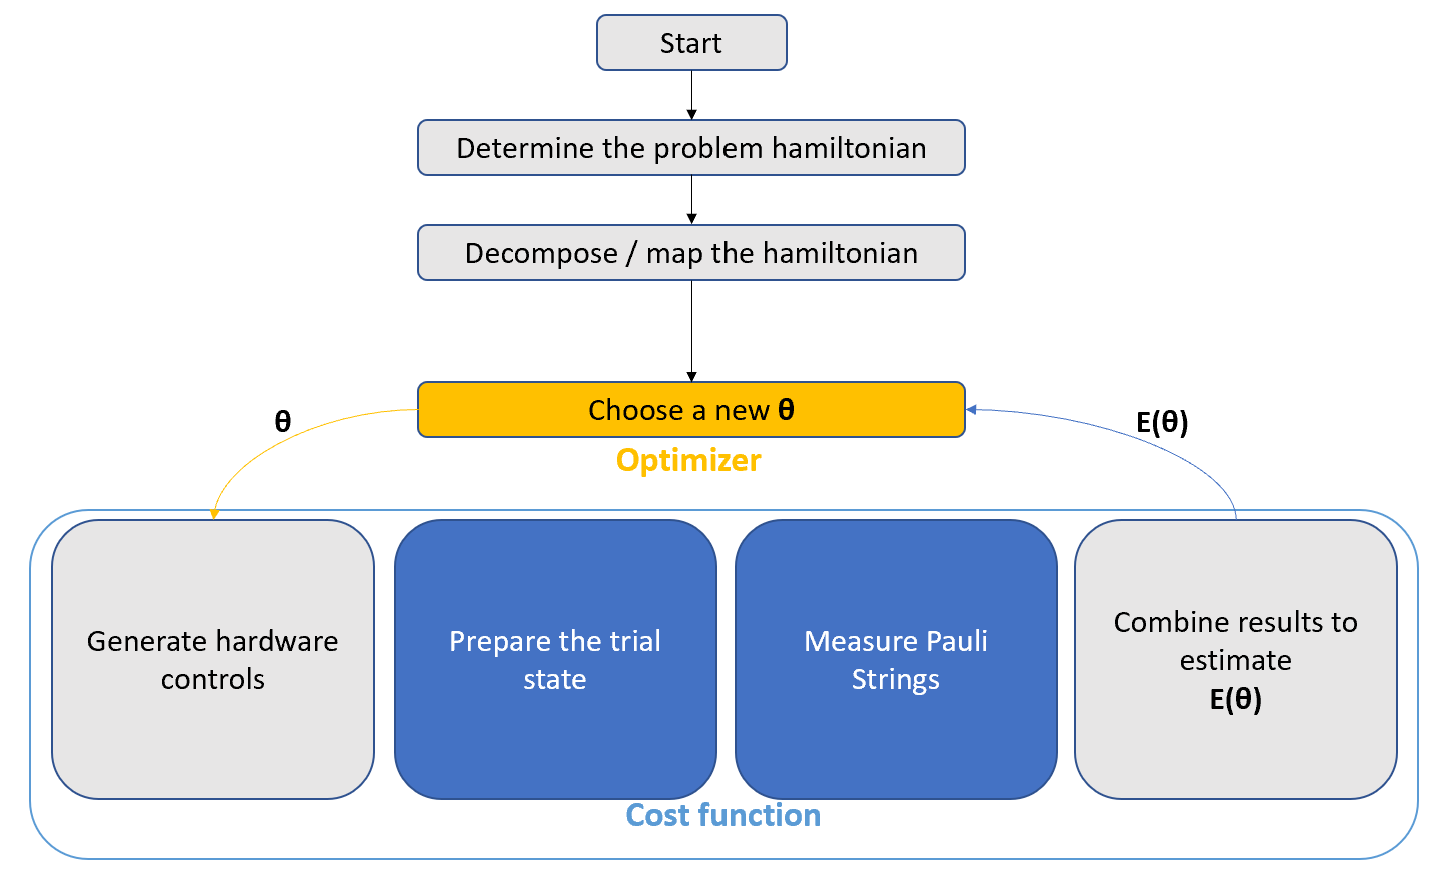


#### Expectation value 

The expectation value of an operator **A** with parameters **θ** can be expressed as $〈A〉_θ = 〈ψ(θ)∣A|ψ(θ)〉$. In quantum chemistry, an operator A is usually a qubit Hamiltonian mapped from a fermionic Hamiltonian of molecules. A qubit Hamiltonian can be written as a linear combination of tensor products of **Pauli operators**. The tensor product of Pauli operators is referred to as **Pauli string**

VQE minimizes the expectation value of the input operator by varying the quantum state |ψ(θ)⟩ with parameters θ

###  VQE components 
In addition to the studied hamiltonian, an instance of VQE will require two other components: the *ansatz* and the *optimizer*. See later for their specific definition in Qiskit.

Then, in order to run the algorithm, a *quantum instance*, or simply a *backend*, will be specified. There are two ways to specify it: either directly in the VQE instance or in the run method when running the instance.

Other components can be passed for the VQE instance:

    vqe = VQE(operator=None, var_form=None, optimizer=None,
    initial_point=None, expectation=None, max_evals_grouped=1,
    aux_operators=None, callback=None, quantum_instance=None)
    
See details of implementation [here](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.VQE.html).

> Remark : it is possible to compare the solution from the VQE instance with the exact solution by using this function :   
    `from qiskit.aqua.algorithm import NumPyEigensolver`  
    `exact = NumPyEigensolver(qubitOp)`  
    `result_exact = exact.run()`

- `operator` (`Union[OperatorBase, LegacyBaseOperator, None]`) – Qubit operator of the Observable

- `var_form` (`Union[QuantumCircuit, VariationalForm, None]`) – A parameterized circuit used as Ansatz for the wave function.

- `optimizer` (`Optional[Optimizer]`) – A classical optimizer.

- `initial_point` (`Optional[ndarray]`) – An optional initial point (i.e. initial parameter values) for the optimizer. If None then VQE will look to the variational form for a preferred point and if not will simply compute a random one.

- `expectation` (`Optional[ExpectationBase]`) – The Expectation converter for taking the average value of the Observable over the var_form state function.

- `max_evals_grouped` (`int`) – Max number of evaluations performed simultaneously. Signals the given optimizer that more than one set of parameters can be supplied so that potentially the expectation values can be computed in parallel. Typically this is possible when a finite difference gradient is used by the optimizer such that multiple points to compute the gradient can be passed and if computed in parallel improve overall execution time.

- `aux_operators` (`Optional[List[Union[OperatorBase, LegacyBaseOperator, None]]]`) – Optional list of auxiliary operators to be evaluated with the eigenstate of the minimum eigenvalue main result and their expectation values returned. For instance in chemistry these can be dipole operators, total particle count operators so we can get values for these at the ground state.

- `callback` (`Optional[Callable[[int, ndarray, float, float], None]]`) – a callback that can access the intermediate data during the optimization. Four parameter values are passed to the callback as follows during each evaluation by the optimizer for its current set of parameters as it works towards the minimum. These are: the evaluation count, the optimizer parameters for the variational form, the evaluated mean and the evaluated standard deviation.`

- `quantum_instance` (`Union[QuantumInstance, BaseBackend, None]`) – Quantum Instance or Backend


### 2.2 - Optimizer  <a name = 'opt'></a>

The optimizer then the quantum part a new set of parameters to vary and improve the ansatz

All the optimizers can be called from `qiskit.aqua.components.optimizers`.   
See details [here](https://qiskit.org/documentation/apidoc/qiskit.aqua.components.optimizers.html).

- **ADAM** : Adam Kingma, Diederik & Ba, Jimmy. (2014). Adam: A Method for Stochastic Optimization;
- **CG** : Conjugate Gradient algorithm;
- **COBYLA** : Constrained Optimization By Linear Approximation algorithm;
- **L_BFGS_B** : Limited-memory BFGS algorithm;
- **NELDER_MEAD** : Nelder-Mead algorithm;
- **P_BFGS** : Limited-memory BFGS algorithm. Parallel instantiations;
- **POWELL** : Powell algorithm;
- **SLSQP** : Sequential Least SQuares Programming algorithm;
- **SPSA** : Simultaneous Perturbation Stochastic Approximation algorithm;
- **TNC** : Truncated Newton algorithm;
- **AQGD** : Analytic Quantum Gradient Descent optimizer class. Performs optimization by gradient descent where gradients are evaluated “analytically” using the quantum circuit evaluating the objective function;
- **NFT** : Nakanishi-Fujii-Todo algorithm;
- **GSLS** : Gaussian-smoothed Line Search.

See this example for initializing an optimizer:

In [77]:
from qiskit.aqua.components.optimizers import COBYLA, SPSA

In [78]:
testOp = COBYLA(maxiter=500)
testOp

### 2.3 - Variational form or ansatz  <a name = 'ansatz'></a>

The **anzatz** (or **trial wavefunction**) is a mathematical guess as to what the answer may be. It prepares the state we need in order to apply variational principle
- Ideally, we want an ansatz that covers many possible states and is shallow
- The better your ansatz is, the better your output will be

There are three ways to create the ansatz for the VQE instance :  
- by using classes of parameterized circuits already implemented in Qiskit (the *N-Local circuits* in `qiskit.circuit.library`). See [here](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits) for all the details about each class.
- by creating a parameterized circuit. See [here](https://qiskit.org/documentation/tutorials/circuits_advanced/1_advanced_circuits.html) for how to create a parameterized circuit. Being able to use it for such algorithms is new in the latest version of Aqua, and is easier than before if one wants to create an ansatz.
- by doing both! Instances of the implemented classes are circuits, therefore any gate can be added to it.

**Example for the existing classes :**

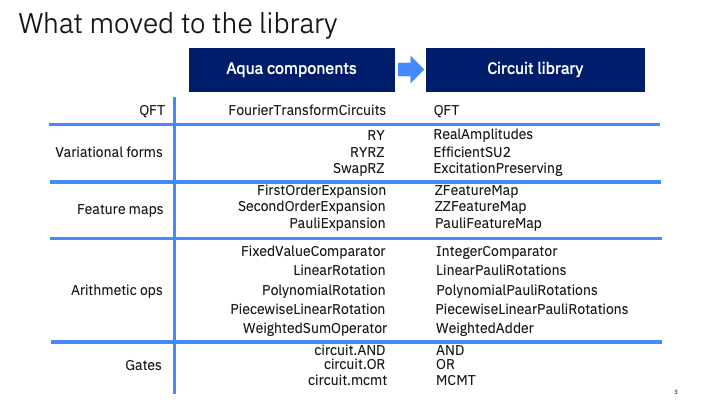

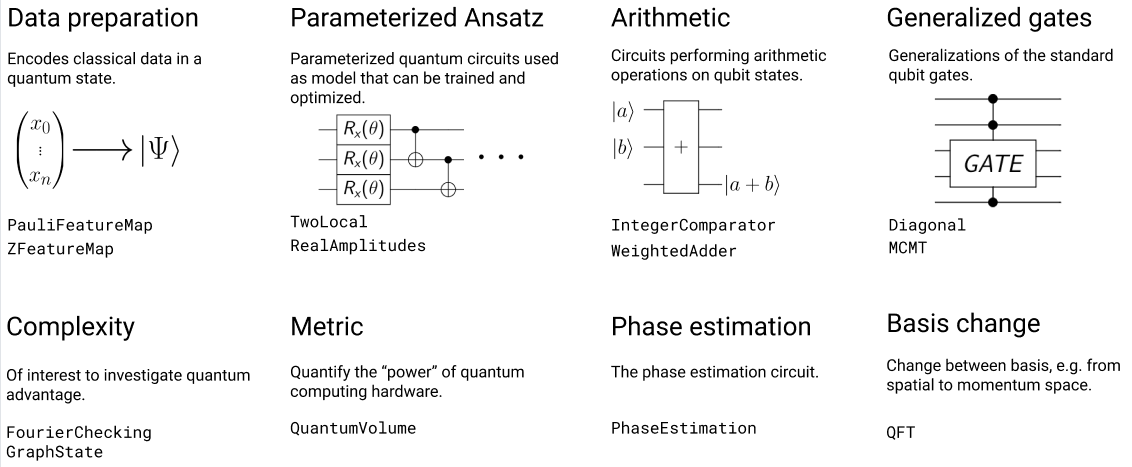

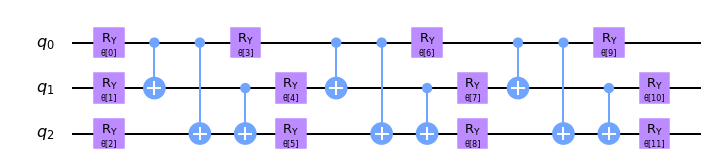

In [79]:
from qiskit.circuit.library import TwoLocal
rotation_blocks = ['ry']
entanglement_blocks = ['cx']
testAnsatz = TwoLocal(3, rotation_blocks, entanglement_blocks, 'full')
testAnsatz.draw(output='mpl')

**Example with a personalized circuit :** **(Parameterized circuits from Terra)**

In [80]:
from qiskit.circuit import Parameter
theta = Parameter('θ')

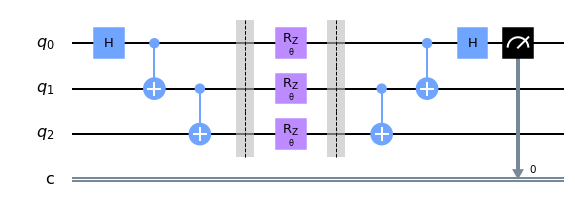

In [81]:
n = 3
qc = QuantumCircuit(n,1)
qc.h(0)
for i in range(n-1):
    qc.cx(i,i+1)
qc.barrier()
qc.rz(theta, range(n))
qc.barrier()
for i in reversed(range(n-1)):
    qc.cx(i, i+1)
qc.h(0)
qc.measure(0, 0)
qc.draw('mpl')

### 2.4 - Hamiltonian  <a name = 'qubitop'></a>

The hamiltonian, describing the problem, can be either created or is already implemented in Qiskit for several optimization problems. See [here](https://qiskit.org/documentation/apidoc/qiskit.optimization.applications.ising.html) for all **Ising Models** of optimization problems already implemented.  
- For those already implemented, one can access the hamiltonian with the function `get_operator()`, returning the operator for the hamiltonian and a constant shift. 


### 2.5 - Quantum instance  <a name = 'inst'></a>

A quantum instance allows to specify a backend and add configuration for the transpilation and the execution, such as the basis gates, the coupling map, backend options, noise model and many other options. See [here](https://qiskit.org/documentation/stubs/qiskit.aqua.QuantumInstance.html) for more details.

## 3 - Simple example over one qubit <a name = 'qubit'></a>

#### Definition of the problem
- Ansatz : the operator $R_y$:
    $$ R_y(\theta) = \begin{pmatrix} \cos(\theta/2) & -\sin(\theta/2) \\  \sin(\theta/2) & \cos(\theta/2) \end{pmatrix}$$
- Hamiltonian : the Pauli gate $Z$:
    $$ Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} $$
    This matrix has the eigenvalues $\{-1, +1\}$ respectively associated with the eigenvectors $\left\{ \begin{pmatrix} 0 \\ 1 \end{pmatrix}, \begin{pmatrix} 1 \\ 0 \end{pmatrix} \right\}$
- Optimizer : whatever we want in the Qiskit implementation.




#### Setting of all the entries required for VQE


##### Optimizer


In [82]:
optimizer = COBYLA(maxiter=500, tol=0.0001)

##### The hamiltonian, `qubitOp`
Here, we want to have the Pauli gate $Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} $.

In [84]:
from qiskit.aqua.operators import X, Y, Z, I, CX, CZ, PauliOp, PrimitiveOp 
# we inmport the One qubit Pauli operators 
qubitOp = Z
print(type(qubitOp))
print (qubitOp.to_matrix())

<class 'qiskit.aqua.operators.primitive_ops.pauli_op.PauliOp'>
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]


##### Variational form

In [85]:
#Using one of the classes of Qiskit
var_form = TwoLocal(qubitOp.num_qubits,'ry',reps=1,insert_barriers=True, skip_final_rotation_layer=True)
print(var_form)

     ┌──────────┐ ░ 
q_0: ┤ RY(θ[0]) ├─░─
     └──────────┘ ░ 


In [86]:
#Creating a parameterized circuit
theta = Parameter('θ')
var_test = QuantumCircuit(1)
var_test.ry(theta,0)
var_test.barrier()
print(var_test)

     ┌───────┐ ░ 
q_0: ┤ RY(θ) ├─░─
     └───────┘ ░ 


#### The VQE instance
When noise is not present in the cost function evaluation (such as when using VQE with a **statevector simulator**), a wide variety of classical optimizers may be useful. 
   - Two such optimizers supported by Qiskit Aqua are the Sequential Least Squares Programming optimizer (SLSQP) and the Constrained Optimization by Linear Approximation optimizer (COBYLA).  
   - It is worth noting that COBYLA only performs one objective function evaluation per optimization iteration. Therefore, if the objective function is noise-free and minimizing the number of performed evaluations is desirable, it is recommended to try **COBYLA**

In [555]:
seed = 10598

backend = Aer.get_backend('statevector_simulator')

quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

In [556]:
vqe = VQE(qubitOp, var_test, optimizer)
vqe2 = VQE(qubitOp, var_form, optimizer)
vqe_run = vqe.run(quantum_instance)
vqe2_run = vqe2.run(quantum_instance)

exact = NumPyEigensolver(qubitOp)
exact_run = exact.run()

print('VQE with the ansatz TwoLocal\n',vqe2_run)
print('\nVQE with the parameterized ansatz\n',vqe_run)
print('\nExact eigensolver\n',exact_run)

VQE with the ansatz TwoLocal
 {'optimal_parameters': {Parameter(θ[0]): 3.1416517698221575}, 'optimal_point': array([3.14165177]), 'optimal_value': -0.9999999982526355, 'optimizer_evals': 24, 'optimizer_time': 0.02596306800842285, 'eigenvalue': (-0.9999999982526355+0j), 'eigenstate': array([-2.95581162e-05+0.j,  1.00000000e+00+0.j]), 'cost_function_evals': 24}

VQE with the parameterized ansatz
 {'optimal_parameters': {Parameter(θ): 3.1417351739520982}, 'optimal_point': array([3.14173517]), 'optimal_value': -0.9999999898439732, 'optimizer_evals': 25, 'optimizer_time': 0.039893150329589844, 'eigenvalue': (-0.9999999898439732+0j), 'eigenstate': array([-7.12601811e-05+0.j,  9.99999997e-01+0.j]), 'cost_function_evals': 25}

Exact eigensolver
 {'eigenvalues': array([-1.+0.j]), 'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 1.+0.j],
            dims=(2,)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)}


#### *Results when executing on a real backend*

In [110]:
#execute on the real hardware 
backend = provider.get_backend('ibmq_paris')
#print(provider.backends())
quantum_instance = QuantumInstance(backend, skip_qobj_validation=False )

In [42]:
vqe2 = VQE(qubitOp, var_form, optimizer)
vqe2_run = vqe2.run(quantum_instance)

exact = NumPyEigensolver(qubitOp)
exact_run = exact.run()

print('VQE with the ansatz TwoLocal\n',vqe2_run)
print('\nExact eigensolver\n',exact_run)

VQE with the ansatz TwoLocal
 {'optimal_parameters': {Parameter(θ[0]): -3.0726827412990825}, 'optimal_point': array([-3.07268274]), 'optimal_value': -0.9648437499999999, 'optimizer_evals': 23, 'optimizer_time': 2506.050560235977, 'eigenvalue': (-0.9648437499999999+0j), 'eigenstate': {'0': 18, '1': 1006}, 'cost_function_evals': 23}

Exact eigensolver
 {'eigenvalues': array([-1.+0.j]), 'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 1.+0.j],
            dims=(2,)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)}


#### *Using SPSA instead of COBYLA* (execute at the end of the presentation as it runs maxiter*2 jobs)

In [578]:
optimizer = SPSA(maxiter=150)
backend = provider.get_backend('ibmq_paris')
quantum_instance = QuantumInstance(backend, skip_qobj_validation=False )

In [579]:
from qiskit.tools import *
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [582]:
vqe2 = VQE(qubitOp, var_form, optimizer)
vqe2_run = vqe2.run(quantum_instance)

print('VQE with the ansatz TwoLocal and SPSA as optimizer \n',vqe2_run)

## 4 - Simple examples over multiple qubits <a name = 'multi_qubits'></a>

##### Let's consider the corresponding Matrix of a 5 nodes graph

In [87]:
G=nx.Graph() #Graph instance
G.add_nodes_from(np.arange(0,n,1)) #Set of nodes of the graph
e_list=[(0,1,1.0),(0,3,1.0),(0,4,1.0), (1,2,1.0),(1,3,1.), (2,3,1.0),(2,4,1.0)] #list of the edges of G with associated weight
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(e_list) #adding created edges to the graph

# colors = ['y' for node in G.nodes()]
# pos = nx.spring_layout(G)
# default_axes = plt.axes(frameon=True)
# nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

In [88]:
from sympy import Matrix
n=5   # we simulate 5 nodes 
w = np.zeros([n,n])

for i in range(n):
    for j in range(i,n):
        edge = G.get_edge_data(i,j, default=0)
        if edge != 0:
            val = edge["weight"]
            w[i,j], w[j,i] = val, val
print ("This is our Hamiltonian: ")
Matrix(w)

This is our Hamiltonian: 


Matrix([
[0.0, 1.0, 0.0, 1.0, 1.0],
[1.0, 0.0, 1.0, 1.0, 0.0],
[0.0, 1.0, 0.0, 1.0, 1.0],
[1.0, 1.0, 1.0, 0.0, 0.0],
[1.0, 0.0, 1.0, 0.0, 0.0]])

#### *We create the operator for the hamiltonian, using the Ising Model max_cut available in qiskit Aqua, describing the problem*

In [89]:
qubitOp, offset = max_cut.get_operator(w)
qubitOp, offset
print (qubitOp)
print(qubitOp.print_details())

Representation: paulis, qubits: 5, size: 7
IIIZZ	(0.5+0j)
IIZZI	(0.5+0j)
IZIIZ	(0.5+0j)
IZIZI	(0.5+0j)
IZZII	(0.5+0j)
ZIIIZ	(0.5+0j)
ZIZII	(0.5+0j)



In [90]:
seed = 10598
optimizer = COBYLA(maxiter=500, tol=0.0001)
# optimizer = SPSA(maxiter=300)
var_form = TwoLocal(qubitOp.num_qubits,'ry',reps=1,insert_barriers=True, skip_final_rotation_layer=True)
vqe = VQE(qubitOp, var_form, optimizer)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)

vqe_result = vqe.run(quantum_instance)

exact = NumPyEigensolver(qubitOp)
exact_run = exact.run()

print('VQE with the ansatz TwoLocal\n',vqe_result)
print('\nExact eigensolver\n',exact_run)

VQE with the ansatz TwoLocal
 {'optimal_parameters': {Parameter(θ[0]): 0.02585392203634785, Parameter(θ[1]): 3.1318447503893814, Parameter(θ[2]): -0.015171140260338492, Parameter(θ[3]): 3.1536410145275644, Parameter(θ[4]): -3.1531931489223384}, 'optimal_point': array([ 0.02585392,  3.13184475, -0.01517114,  3.15364101, -3.15319315]), 'optimal_value': -2.4990234375, 'optimizer_evals': 89, 'optimizer_time': 5.821265459060669, 'eigenvalue': (-2.4990234375+0j), 'eigenstate': {'10010': 2, '11010': 8188, '11011': 1, '11110': 1}, 'cost_function_evals': 89}

Exact eigensolver
 {'eigenvalues': array([-2.5+0.j]), 'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 

In [91]:
print('energy:', vqe_result['optimal_value'])
print('time:', vqe_result['optimizer_time'])

energy: -2.4990234375
time: 5.821265459060669


In [92]:
print(var_form.parameters)
ansatz_circuit = vqe.construct_circuit(testAnsatz.parameters)[0]
print("\n Ansatz Circuit :\n", ansatz_circuit )
expectation1 = vqe.construct_expectation(testAnsatz.parameters)[1]
print("\n Expectation value measurement 1 :\n", expectation1 )
expectation0 = vqe.construct_expectation(testAnsatz.parameters)[0]
print("\n Expectation value measurement 0 :\n", expectation0 )

{Parameter(θ[3]), Parameter(θ[4]), Parameter(θ[0]), Parameter(θ[2]), Parameter(θ[1])}

 Ansatz Circuit :
      ┌───────────┐ ░ 
q_0: ┤ RY(θ[10]) ├─░─
     └┬──────────┤ ░ 
q_1: ─┤ RY(θ[5]) ├─░─
      ├──────────┤ ░ 
q_2: ─┤ RY(θ[7]) ├─░─
      ├──────────┤ ░ 
q_3: ─┤ RY(θ[0]) ├─░─
      ├──────────┤ ░ 
q_4: ─┤ RY(θ[4]) ├─░─
      └──────────┘ ░ 

 Expectation value measurement 1 :
 CircuitStateFn(
     ┌───────────┐ ░ 
q_0: ┤ RY(θ[10]) ├─░─
     └┬──────────┤ ░ 
q_1: ─┤ RY(θ[5]) ├─░─
      ├──────────┤ ░ 
q_2: ─┤ RY(θ[7]) ├─░─
      ├──────────┤ ░ 
q_3: ─┤ RY(θ[0]) ├─░─
      ├──────────┤ ░ 
q_4: ─┤ RY(θ[4]) ├─░─
      └──────────┘ ░ 
)

 Expectation value measurement 0 :
 OperatorMeasurement(AbelianSummedOp([
  0.5 * IIIZZ,
  0.5 * IIZZI,
  0.5 * IZIIZ,
  0.5 * IZIZI,
  0.5 * IZZII,
  0.5 * ZIIIZ,
  0.5 * ZIZII
]))


## 5 - Small aside - Operator Class <a name = 'operator_class'></a>
Many things can be done with the `Operator` class, see [this tutorial](https://qiskit.org/documentation/tutorials/circuits_advanced/2_operators_overview.html) for explanation on how to create and manipulate such operators.
- The Operator class is used in Qiskit to represent matrix operators acting on a quantum system
- Several other classes in Qiskit can be directly converted to an Operator object using the operator initialization method

    - Pauli objects
    - Gate and Instruction objects
    - QuantumCircuits objects

In [72]:
# pauli objects 
from qiskit.quantum_info.operators import Operator, Pauli, Clifford 
qubitOp = Pauli(label='X')
print(qubitOp)
print(type(qubitOp))

# create an Operator (Terra operator) using this object 
op=Operator(qubitOp)
print(op)
print(type(op))

# Create an Aqua Operator using this object
from qiskit.aqua.operators import PrimitiveOp, PauliOp
aquaOp = PauliOp(qubitOp)
print(aquaOp)
print(type(aquaOp))

aquaOp = PrimitiveOp(qubitOp)
print(aquaOp)
print(type(aquaOp))


X
<class 'qiskit.quantum_info.operators.pauli.Pauli'>
Operator([[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],
         input_dims=(2,), output_dims=(2,))
<class 'qiskit.quantum_info.operators.operator.Operator'>
X
<class 'qiskit.aqua.operators.primitive_ops.pauli_op.PauliOp'>
X
<class 'qiskit.aqua.operators.primitive_ops.pauli_op.PauliOp'>


#### VQE using Bell circuit as Operator 

Clifford: Stabilizer = ['+XX', '+ZZ'], Destabilizer = ['+IZ', '+XI']


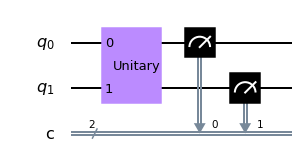

In [198]:
# Bell state generation circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

cliff = Clifford(qc)
print(cliff)

# Create a Clifford operator 
CL = Operator(Clifford(cliff))

# Add to a circuit
circ = QuantumCircuit(2, 2)
circ.append(CL, [0, 1])
circ.measure([0,1], [0,1])
circ.draw('mpl')

In [199]:
from qiskit.aqua.operators import MatrixOperator, PrimitiveOp, MatrixOp, PauliOp

qubitOp = MatrixOp(CL)
print (qubitOp)
Matrix(qubitOp.to_matrix())


Operator([[ 0.70710678+0.j,  0.70710678+0.j,  0.        +0.j,
            0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
           -0.70710678+0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
            0.70710678+0.j],
          [ 0.70710678+0.j, -0.70710678+0.j,  0.        +0.j,
            0.        +0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


Matrix([
[0.707106781186547,  0.707106781186547,                 0,                  0],
[                0,                  0, 0.707106781186547, -0.707106781186547],
[                0,                  0, 0.707106781186547,  0.707106781186547],
[0.707106781186547, -0.707106781186547,                 0,                  0]])

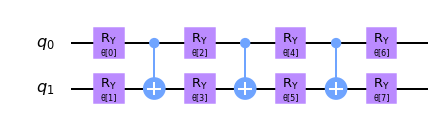

In [200]:
# Ansatz definition
rotation_blocks = ['ry']
entanglement_blocks = ['cx']
testAnsatz = TwoLocal(2, rotation_blocks, entanglement_blocks, 'full')
testAnsatz.draw(output='mpl')

In [201]:
seed = 10598

spsa = SPSA(maxiter=100)
vqe = VQE(qubitOp, testAnsatz, spsa)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)

vqe_result = vqe.run(quantum_instance)

print('VQE with the ansatz testAnsatz\n',vqe_result)


VQE with the ansatz testAnsatz
 {'optimal_parameters': {Parameter(θ[0]): -5.196036447639922, Parameter(θ[1]): -3.1797564235561446, Parameter(θ[2]): 5.108643011654059, Parameter(θ[3]): -6.572252175977025, Parameter(θ[4]): -0.6821299094471205, Parameter(θ[5]): -2.7220070935583247, Parameter(θ[6]): 1.7495428725279334, Parameter(θ[7]): 1.7194031623781023}, 'optimal_point': array([-5.19603645, -3.17975642,  5.10864301, -6.57225218, -0.68212991,
       -2.72200709,  1.74954287,  1.71940316]), 'optimal_value': -0.6836388950864365, 'optimizer_time': 3.961374521255493, 'eigenvalue': (-0.6836388950864365+0j), 'eigenstate': {'00': 4, '01': 3913, '11': 4275}, 'cost_function_evals': 241}


In [202]:
print("Variable form parameters :\n" ,testAnsatz.parameters)

# Generate the ansatz circuit and expectation value measurement
vqe_circuit = vqe.construct_circuit(testAnsatz.parameters)[0]
print(vqe_circuit)

expectation1 = vqe.construct_expectation(testAnsatz.parameters)[1]
print("\n Expectation value measurement 1 :\n", expectation1 )

expectation0 = vqe.construct_expectation(testAnsatz.parameters)[0]
print("\n Expectation value measurement 0 :\n", expectation0 )

Variable form parameters :
 {Parameter(θ[7]), Parameter(θ[3]), Parameter(θ[2]), Parameter(θ[6]), Parameter(θ[0]), Parameter(θ[4]), Parameter(θ[5]), Parameter(θ[1])}
     ┌──────────┐     ┌──────────┐     ┌──────────┐     ┌──────────┐
q_0: ┤ RY(θ[1]) ├──■──┤ RY(θ[2]) ├──■──┤ RY(θ[0]) ├──■──┤ RY(θ[6]) ├
     ├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤
q_1: ┤ RY(θ[5]) ├┤ X ├┤ RY(θ[3]) ├┤ X ├┤ RY(θ[4]) ├┤ X ├┤ RY(θ[7]) ├
     └──────────┘└───┘└──────────┘└───┘└──────────┘└───┘└──────────┘

 Expectation value measurement 1 :
 CircuitStateFn(
     ┌──────────┐     ┌──────────┐     ┌──────────┐     ┌──────────┐
q_0: ┤ RY(θ[1]) ├──■──┤ RY(θ[2]) ├──■──┤ RY(θ[0]) ├──■──┤ RY(θ[6]) ├
     ├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤
q_1: ┤ RY(θ[5]) ├┤ X ├┤ RY(θ[3]) ├┤ X ├┤ RY(θ[4]) ├┤ X ├┤ RY(θ[7]) ├
     └──────────┘└───┘└──────────┘└───┘└──────────┘└───┘└──────────┘
)

 Expectation value measurement 0 :
 OperatorMeasurement(Operator([[ 0.70710678+0.j,  0.70

### Example using a circuit representing your Hamiltonian 

Operator([[-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


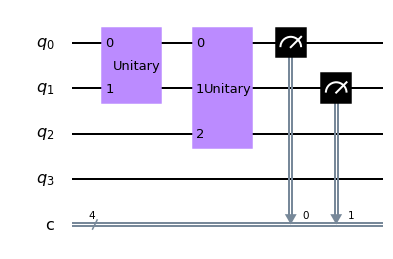

In [124]:
# Create an operator
XX = Operator(Pauli(label='XX'))
YY = Operator(Pauli(label='YY'))
print((XX@YY))

XXX = Operator(Pauli(X,label='XXX'))

# Add to a circuit
circ = QuantumCircuit(4, 4)
circ.append(XX, [0, 1])
circ.append(XXX, [0, 1, 2])
circ.measure([0,1], [0,1])
circ.draw('mpl')

In [152]:
# Transform Terra Operator Class into Aqua Operator using PrimitiveOp 
from qiskit.aqua.operators import PrimitiveOp, PauliOp, MatrixOp
qubitOperator = MatrixOp((XXX))
print(type(qubitOperator))
print(qubitOperator.to_matrix())

<class 'qiskit.aqua.operators.primitive_ops.matrix_op.MatrixOp'>
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


### Example using a matrix representing your Hamiltonian 

In [130]:
# Another example using an existing matrix representing your hamiltonian 
Hamiltonian = [[0, 1, 0, 1, 1, 0], [ 1, 0, 1, 1, 0, 1], [ -1, 0, 1, 0, 0, 1], [ 1, 0, 0, 1, 0, 1], [ 1, 0, 1, 0, 0, -1], [ 1, 0, 0, -1, 0, 1]]
Matrix(Hamiltonian)

Matrix([
[ 0, 1, 0,  1, 1,  0],
[ 1, 0, 1,  1, 0,  1],
[-1, 0, 1,  0, 0,  1],
[ 1, 0, 0,  1, 0,  1],
[ 1, 0, 1,  0, 0, -1],
[ 1, 0, 0, -1, 0,  1]])

In [132]:
# Use Aqua's operator flow to turn this matrix into an operator. You can also see the Pauli representation.
hamiltonian_operator = MatrixOperator(Hamiltonian).to_opflow()
print(type(hamiltonian_operator))
print (hamiltonian_operator.to_matrix()) 

<class 'qiskit.aqua.operators.primitive_ops.matrix_op.MatrixOp'>
[[ 0.+0.j  1.+0.j  0.+0.j  1.+0.j  1.+0.j  0.+0.j]
 [ 1.+0.j  0.+0.j  1.+0.j  1.+0.j  0.+0.j  1.+0.j]
 [-1.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  1.+0.j]
 [ 1.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  1.+0.j]
 [ 1.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j -1.+0.j]
 [ 1.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  1.+0.j]]


### Example defining the Hamiltonian in Pauli notation 

In [141]:
from qiskit.aqua.operators import X, Y, Z, I
opxxxx =  (-1.0523732 * I^I^X^Z) + (0.39793742 * I^Z^X^I) + (-0.3979374 * I^Z^I^X) \
    + (-0.0112801 * I^Z^Z^X) + (0.18093119 * Z^X^X^I)
print(opxxxx)
Matrix(opxxxx.to_matrix())

SummedOp([
  -1.0523732 * IIXZ,
  0.39793742 * IZXI,
  -0.3979374 * IZIX,
  -0.0112801 * IZZX,
  0.18093119 * ZXXI
])


Matrix([
[          0, -0.4092175, -0.65443578,          0,           0,          0,  0.18093119,          0,           0,           0,           0,           0,           0,           0,           0,           0],
[ -0.4092175,          0,           0, 1.45031062,           0,          0,           0, 0.18093119,           0,           0,           0,           0,           0,           0,           0,           0],
[-0.65443578,          0,           0, -0.3866573,  0.18093119,          0,           0,          0,           0,           0,           0,           0,           0,           0,           0,           0],
[          0, 1.45031062,  -0.3866573,          0,           0, 0.18093119,           0,          0,           0,           0,           0,           0,           0,           0,           0,           0],
[          0,          0,  0.18093119,          0,           0,  0.4092175, -1.45031062,          0,           0,           0,           0,           0,           0,  

In [144]:
op =  (-1.0523732 * I^Y) + (0.39793742 * I^Z) + (-0.3979374 * Z^Y) \
    + (-0.0112801 * Z^Z) + (0.18093119 * X^X)

print(op)
Matrix(op.to_matrix())

SummedOp([
  -1.0523732 * IY,
  0.39793742 * IZ,
  -0.3979374 * ZY,
  -0.0112801 * ZZ,
  0.18093119 * XX
])


Matrix([
[  0.38665732, 1.4503106*I,            0,  0.18093119],
[-1.4503106*I, -0.38665732,   0.18093119,           0],
[           0,  0.18093119,   0.40921752, 0.6544358*I],
[  0.18093119,           0, -0.6544358*I, -0.40921752]])

In [149]:
# let's define another ansatz using EfficientSU2 and called trial_wavefunction 
trial_wavefunction = EfficientSU2(num_qubits = op.num_qubits, reps=3)
trial_wavefunction.draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
q_0: ┤ RY(θ[0]) ├┤ RZ(θ[2]) ├──■──┤ RY(θ[4]) ├┤ RZ(θ[6]) ├──■──┤ RY(θ[8]) ├»
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ RZ(θ[7]) ├┤ X ├┤ RY(θ[9]) ├»
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
«     ┌───────────┐     ┌───────────┐┌───────────┐
«q_0: ┤ RZ(θ[10]) ├──■──┤ RY(θ[12]) ├┤ RZ(θ[14]) ├
«     ├───────────┤┌─┴─┐├───────────┤├───────────┤
«q_1: ┤ RZ(θ[11]) ├┤ X ├┤ RY(θ[13]) ├┤ RZ(θ[15]) ├
«     └───────────┘└───┘└───────────┘└───────────┘

In [150]:
seed = 10598

spsa = SPSA(maxiter=100)
vqe = VQE(op, trial_wavefunction, spsa)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)

vqe_result = vqe.run(quantum_instance)

print('VQE with the ansatz testAnsatz\n',vqe_result)

VQE with the ansatz testAnsatz
 {'optimal_parameters': {Parameter(θ[0]): 0.8538734877899596, Parameter(θ[10]): -3.9376962880113884, Parameter(θ[11]): 3.7923161838704815, Parameter(θ[12]): -3.9863458728180814, Parameter(θ[13]): 4.858322908193151, Parameter(θ[14]): -1.2018615488308055, Parameter(θ[15]): -0.45537148123691457, Parameter(θ[1]): 0.2999644734612738, Parameter(θ[2]): -1.9357908722219592, Parameter(θ[3]): 0.03383439984356976, Parameter(θ[4]): -1.9018109245127772, Parameter(θ[5]): -2.0680960240394124, Parameter(θ[6]): 1.7723527249776663, Parameter(θ[7]): 3.2890524199129714, Parameter(θ[8]): 1.5110706724671241, Parameter(θ[9]): -3.4027048362427617}, 'optimal_point': array([ 0.85387349, -3.93769629,  3.79231618, -3.98634587,  4.85832291,
       -1.20186155, -0.45537148,  0.29996447, -1.93579087,  0.0338344 ,
       -1.90181092, -2.06809602,  1.77235272,  3.28905242,  1.51107067,
       -3.40270484]), 'optimal_value': -1.4970132892578123, 'optimizer_time': 31.01555299758911, 'eigen

In [151]:
print(op)
print(len(vqe.construct_circuit(trial_wavefunction.parameters)))
print("Variable form parameters :\n" ,trial_wavefunction.parameters)
# Generate the ansatz circuit and expectation value measurement
vqe_circuit0 = vqe.construct_circuit(trial_wavefunction.parameters)[0]
print("\n VQE full circuit 0 :\n",vqe_circuit0)
vqe_circuit1 = vqe.construct_circuit(trial_wavefunction.parameters)[1]
print("\n VQE full circuit 1 :\n",vqe_circuit1)
vqe_circuit2 = vqe.construct_circuit(trial_wavefunction.parameters)[2]
print("\n VQE full circuit 2 :\n",vqe_circuit2)
print("*********************************************")
print(len(vqe.construct_expectation(trial_wavefunction.parameters)))
expectation0 = vqe.construct_expectation(trial_wavefunction.parameters)[0]
print("\n Expectation value measurement 0 :\n", expectation0 )
expectation1 = vqe.construct_expectation(trial_wavefunction.parameters)[1]
print("\n Expectation value measurement 1 :\n", expectation1 )
expectation2 = vqe.construct_expectation(trial_wavefunction.parameters)[2]
print("\n Expectation value measurement 2 :\n", expectation2 )

SummedOp([
  -1.0523732 * IY,
  0.39793742 * IZ,
  -0.3979374 * ZY,
  -0.0112801 * ZZ,
  0.18093119 * XX
])
3
Variable form parameters :
 {Parameter(θ[14]), Parameter(θ[11]), Parameter(θ[1]), Parameter(θ[5]), Parameter(θ[2]), Parameter(θ[6]), Parameter(θ[10]), Parameter(θ[13]), Parameter(θ[8]), Parameter(θ[12]), Parameter(θ[15]), Parameter(θ[0]), Parameter(θ[9]), Parameter(θ[4]), Parameter(θ[3]), Parameter(θ[7])}

 VQE full circuit 0 :
      ┌──────────┐ ┌──────────┐     ┌───────────┐┌──────────┐     ┌──────────┐»
q_0: ┤ RY(θ[7]) ├─┤ RZ(θ[2]) ├──■──┤ RY(θ[15]) ├┤ RZ(θ[6]) ├──■──┤ RY(θ[8]) ├»
     ├──────────┤┌┴──────────┤┌─┴─┐└┬──────────┤├──────────┤┌─┴─┐├──────────┤»
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[12]) ├┤ X ├─┤ RY(θ[5]) ├┤ RZ(θ[4]) ├┤ X ├┤ RY(θ[9]) ├»
     └──────────┘└───────────┘└───┘ └──────────┘└──────────┘└───┘└──────────┘»
«     ┌───────────┐     ┌──────────┐┌───────────┐┌─────┐┌───┐
«q_0: ┤ RZ(θ[13]) ├──■──┤ RY(θ[0]) ├┤ RZ(θ[14]) ├┤ SDG ├┤ H ├
«     ├───────────┤┌─┴─┐├──────────┤├───